# 端到端模型执行

# 1. 模型准备

In [1]:
!python3 -m pip install mlc-ai-nightly -f https://mlc.ai/wheels
!python3 -m pip install torch torchvision torchaudio torchsummary --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     |████████████████████████████████| 44.1 MB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cpu


In [2]:
import numpy as np
import pickle as pkl
import torch
import torch.nn.functional as F
import torchvision
import tvm
import tvm.testing

from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms
from tvm import topi, relax, te, contrib
from tvm.script import tir as T, relax as R


from __future__ import annotations

In [3]:
import IPython

def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.lexers import Python3Lexer
    from pygments.formatters import HtmlFormatter
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

## **pytorch定义的模型**

**打印下模型的结构，能够对照着用tvm的topi去替代**

In [8]:
batch_size = 4
input_shape = (batch_size, 1, 28, 28)  # NCHW layout


def pytorch_model():
    list = []
    list.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), bias=True))
    list.append(nn.ReLU())
    list.append(nn.MaxPool2d(kernel_size=(2, 2)))
    list.append(nn.Flatten())
    list.append(nn.Linear(in_features=5408, out_features=100, bias=True))
    list.append(nn.ReLU())
    list.append(nn.Linear(in_features=100, out_features=10, bias=True))
    list.append(nn.Softmax(dim=1))

    model = nn.Sequential(*list).cpu()
    name_map = {
        "0.weight": "conv2d_weight",
        "0.bias": "conv2d_bias",
        "4.weight": "linear0_weight",
        "4.bias": "linear0_bias",
        "6.weight": "linear1_weight",
        "6.bias": "linear1_bias",
    }
    for name, param in model.named_parameters():
        param.data = torch.from_numpy(weight_map[name_map[name]]).cpu()
    return model
torch_model = pytorch_model()
# print(torch_model)


from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t = torch_model.to(device)
summary(t, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
           Flatten-4                 [-1, 5408]               0
            Linear-5                  [-1, 100]         540,900
              ReLU-6                  [-1, 100]               0
            Linear-7                   [-1, 10]           1,010
           Softmax-8                   [-1, 10]               0
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.41
Params size (MB): 2.07
Estimated Total Size (MB): 2.49
----------------------------------------------------------------


### run一下模型

In [5]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_assignment_params.pkl

--2022-07-29 07:55:30--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_assignment_params.pkl
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_assignment_params.pkl [following]
--2022-07-29 07:55:31--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_assignment_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2169350 (2.1M) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_assignment_params.pkl’

fasionmnist_mlp_ass 100%[===================>]   2.07M  --.-KB/s    in 0.01s   

2022-07-29 07:

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

predict: Ankle boot, label: Ankle boot

Test set: Average loss: -0.8369, Accuracy: 8388/10000 (84%)



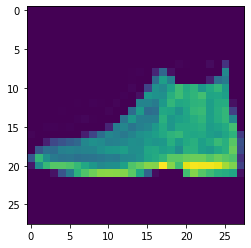

In [7]:
# Load the weight map from file.
# The prediction accuracy of the weight map on test data is around 83.3%.
weight_map = pkl.load(open("fasionmnist_mlp_assignment_params.pkl", "rb"))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        print_img = True
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, label, reduction="sum").item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            if print_img:
                imshow(data[0])
                print("predict: {}, label: {}".format(class_names[pred[0][0]], class_names[label[0]]))
                print_img = False
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def imshow(img):
    img = img / 2 + 0.5
    # npimg = img.numpy()
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    img = img.reshape(1, 28, 28).numpy()
    plt.figure()
    plt.imshow(img[0])  


test_data = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False)
test(pytorch_model(), test_loader)

# 2.从pytorch迁移模型

### relax.BlockBuilder，它能够从空白的IRModule开始一步步的构建端到端模型

- relex.BlockBuilder 用于迁移模型
- emit_te(func, *input) 将张量表达式的描述转化为TensorIR的call_tir形式


In [ ]:
def relu(A):
    print(A.shape)
    B = te.compute(shape=(128, 128), fcompute=lambda i, j: te.max(A[i, j], 0), name="B")
    print(B.shape)
    return B

def emit_te_example():
    bb = relax.BlockBuilder()
    x = relax.Var("x", (128, 128), relax.DynTensorType(2, "float32"))
    print(x.shape)
    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit_te(relu, x)
            # lv1 = bb.emit_te(relu_1, lv0)
            gv = bb.emit_output(lv0)
        bb.emit_func_output(gv)
    return bb.get()

In [ ]:
mod = emit_te_example()
IPython.display.HTML(code2html(mod.script()))

(128, 128)
[128, 128]
[128, 128]


### 实践1

In [ ]:
def conv2d_1(Input, fliter, bias):
  lv1_0 = tvm.topi.nn.conv2d(Input, fliter, 1, 0, 1)
  return tvm.topi.add(lv1_0, bias)
  
def relu_2(Input):
  tvm.topi.nn.pool2d
  return tvm.topi.nn.relu(Input)

def maxPool_3(Input):
  # return tvm.topi.nn.pool2d(Input, (2, 2), (0, 0) , 1, (0, 0, 0, 0), 'max', False, 'NHCW', False)
  return tvm.topi.nn.pool2d(data = Input, kernel = [2, 2], dilation = (1,1), stride = [2,2], padding = [0,0,0,0], pool_type = 'max')
   
def flatten_4(Input):
  return tvm.topi.nn.flatten(Input)

def linear_5(Input, weight, bias):
  lv5_0 = tvm.topi.nn.dense(Input, weight)
  return tvm.topi.add(lv5_0, bias) 
    
def relu_6(Input):
  return tvm.topi.nn.relu(Input)

def linear_7(Input, weight ,bias):
  lv7_0 = tvm.topi.nn.dense(Input, weight)
  return tvm.topi.add(lv7_0, bias) 

def softMax_8(Intput):
  return tvm.topi.nn.softmax(Intput, axis=- 1)

def create_model_via_emit_te():
    bb = relax.BlockBuilder()
    x = relax.Var("x", input_shape, relax.DynTensorType(batch_size, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
          lv1 = bb.emit_te(conv2d_1, x, conv2d_weight, conv2d_bias)
          lv2 = bb.emit_te(relu_2, lv1)
          lv3 = bb.emit_te(maxPool_3, lv2)
          lv4 = bb.emit_te(flatten_4, lv3)
          lv5 = bb.emit_te(linear_5, lv4, linear0_weight, linear0_bias)
          lv6 = bb.emit_te(relu_6, lv5)
          lv7 = bb.emit_te(linear_7, lv6, linear1_weight, linear1_bias)
          lv8 = bb.emit_te(softMax_8, lv7)

          gv = bb.emit_output(lv8)
        bb.emit_func_output(gv)

    return bb.get()
mod_0 = create_model_via_emit_te()
# IPython.display.HTML(code2html(mod.script()))

In [11]:
def conv2d_1(Input, fliter, bias):
  lv1_0 = tvm.topi.nn.conv2d(Input, fliter, 1, 0, 1)
  return tvm.topi.add(lv1_0, bias)
  
def relu_2(Input):
  # tvm.topi.nn.pool2d
  return tvm.topi.nn.relu(Input)

def maxPool_3(Input):
  # return tvm.topi.nn.pool2d(Input, (2, 2), (0, 0) , 1, (0, 0, 0, 0), 'max', False, 'NHCW', False)
  return tvm.topi.nn.pool2d(data = Input, kernel = [2, 2], dilation = (1,1), stride = [2,2], padding = [0,0,0,0], pool_type = 'max')
   
def flatten_4(Input):
  return tvm.topi.nn.flatten(Input)

def linear_5(Input, weight, bias):
  lv5_0 = tvm.topi.nn.dense(Input, weight)
  return tvm.topi.add(lv5_0, bias) 
    
def relu_6(Input):
  return tvm.topi.nn.relu(Input)

def linear_7(Input, weight ,bias):
  lv7_0 = tvm.topi.nn.dense(Input, weight)
  return tvm.topi.add(lv7_0, bias) 

def softMax_8(Intput):
  return tvm.topi.nn.softmax(Intput, axis=- 1)

def create_model_via_emit_te():
    bb = relax.BlockBuilder()
    x = relax.Var("x", input_shape, relax.DynTensorType(batch_size, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
          lv1 = bb.emit_te(conv2d_1, x, conv2d_weight, conv2d_bias)
          lv2 = bb.emit_te(relu_2, lv1)
          lv3 = bb.emit_te(maxPool_3, lv2)
          lv4 = bb.emit_te(flatten_4, lv3)
          lv5 = bb.emit_te(linear_5, lv4, linear0_weight, linear0_bias)
          lv6 = bb.emit_te(relu_6, lv5)
          lv7 = bb.emit_te(linear_7, lv6, linear1_weight, linear1_bias)
          lv8 = bb.emit_te(softMax_8, lv7)

          gv = bb.emit_output(lv8)
        bb.emit_func_output(gv)

    return bb.get()


def build_mod(mod):
    exec = relax.vm.build(mod, "llvm")
    dev = tvm.cpu()
    vm = relax.VirtualMachine(exec, dev)
    return vm


def check_equivalence(mod, torch_model, test_loader):
    torch_model.eval()
    with torch.no_grad():
        rt_mod = build_mod(mod)
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output_from_pytorch = torch_model(data).numpy()
            output_from_relax = rt_mod["main"](tvm.nd.array(data, tvm.cpu())).numpy()
            # print(output_from_pytorch)
            # print('---------------------------')
            # print(output_from_relax)
            tvm.testing.assert_allclose(output_from_pytorch, output_from_relax, rtol=1e-4)


test_data = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

mod_0 = create_model_via_emit_te()
torch_model = pytorch_model()

check_equivalence(mod_0, torch_model, test_loader)
print("pass")
# IPython.display.HTML(code2html(mod.script()))

pass


# 3. 使用库

In [ ]:
filters = torch.randn(8, 4, 3, 3)
inputs = torch.randn(1, 4, 5, 5)
a = torch.nn.functional.conv2d(inputs, filters, padding=1)
print(a)

In [12]:
@tvm.register_func("env.conv2d", override=True)
def torch_conv2d(
    x: tvm.nd.NDArray,
    w: tvm.nd.NDArray,
    out : tvm.nd.NDArray
):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    out_torch = torch.from_dlpack(out)
    t = torch.nn.functional.conv2d(x_torch, w_torch)
    out_torch.copy_(t)

    

def conv2d_1(Input, fliter):
  return tvm.topi.nn.conv2d(Input, fliter, 1, 0, 1)

def add(Input, bias):
  return tvm.topi.add(Input, bias)   


def relu_2(Input):
  tvm.topi.nn.pool2d
  return tvm.topi.nn.relu(Input)

def maxPool_3(Input):
  # return tvm.topi.nn.pool2d(Input, (2, 2), (0, 0) , 1, (0, 0, 0, 0), 'max', False, 'NHCW', False)
  return tvm.topi.nn.pool2d(data = Input, kernel = [2, 2], dilation = (1,1), stride = [2,2], padding = [0,0,0,0], pool_type = 'max')
   
def flatten_4(Input):
  return tvm.topi.nn.flatten(Input)

def linear_5(Input, weight, bias):
  lv5_0 = tvm.topi.nn.dense(Input, weight)
  return tvm.topi.add(lv5_0, bias) 
    
def relu_6(Input):
  return tvm.topi.nn.relu(Input)

def linear_7(Input, weight ,bias):
  lv7_0 = tvm.topi.nn.dense(Input, weight)
  return tvm.topi.add(lv7_0, bias) 

def softMax_8(Intput):
  return tvm.topi.nn.softmax(Intput, axis=- 1)

def create_model_via_emit_te():
    bb = relax.BlockBuilder()
    x = relax.Var("x", input_shape, relax.DynTensorType(batch_size, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
          lv1_0 = bb.emit(relax.op.call_tir(relax.extern("env.conv2d"), (x, conv2d_weight),(4, 32, 26, 26), dtype="float32"))
          lv1 = bb.emit_te(add, lv1_0, conv2d_bias)
          lv2 = bb.emit_te(relu_2, lv1)
          lv3 = bb.emit_te(maxPool_3, lv2)
          lv4 = bb.emit_te(flatten_4, lv3)
          lv5 = bb.emit_te(linear_5, lv4, linear0_weight, linear0_bias)
          lv6 = bb.emit_te(relu_6, lv5)
          lv7 = bb.emit_te(linear_7, lv6, linear1_weight, linear1_bias)
          lv8 = bb.emit_te(softMax_8, lv7)

          gv = bb.emit_output(lv8)
        bb.emit_func_output(gv)

    return bb.get()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
mod = create_model_via_emit_te()
check_equivalence(mod, torch_model, test_loader)

**另一位同学的写法**

In [15]:
# %%
# register pytorch conv2d function
@tvm.register_func("env.conv2d", override=True)
def torch_conv2d(
    x: tvm.nd.NDArray,
    w: tvm.nd.NDArray,
    b: tvm.nd.NDArray,
    out: tvm.nd.NDArray
):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    t = torch.nn.functional.conv2d(x_torch, w_torch)
    out_torch.copy_(t)
    torch.add(out_torch, b_torch, out = out_torch)
# %%
# function for mixed pytorch + topi model
def mixed_pytorch_model(A, w4, b4, w6, b6):
    B = topi.nn.relu(A)
    B = topi.nn.pool2d(B, [2,2], [2,2], [1,1], padding=[0,0,0,0], pool_type="max")
    B = topi.nn.flatten(B)
    B = topi.matmul(B, w4, transp_b=True)

    B = topi.add(B, b4)
    B = topi.nn.relu(B)
    B = topi.matmul(B, w6, transp_b=True)
    
    B = topi.add(B, b6)
    B = topi.nn.softmax(B)
    return B
# %%
# function to create IR with mixed model
def create_model_with_torch_func():
    bb = relax.BlockBuilder()

    x = relax.Var("x", input_shape, relax.DynTensorType(4, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")
    
    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit(relax.op.call_tir(relax.extern("env.conv2d"), (x, conv2d_weight, conv2d_bias),(4, 32, 26, 26), dtype="float32"))
            lv1 = bb.emit_te(
                mixed_pytorch_model, lv0,
                linear0_weight,
                linear0_bias,
                linear1_weight,
                linear1_bias
            )
            gv = bb.emit_output(lv1)
        bb.emit_func_output(gv)

    return bb.get()


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
mod = create_model_with_torch_func()
check_equivalence(mod, torch_model, test_loader)

# 4.端到端模型中的程序变换

In [17]:
def conv2d_1(Input, fliter):
  return tvm.topi.nn.conv2d(Input, fliter, 1, 0, 1)

def add(Input, bias):
  return tvm.topi.add(Input, bias)   


def relu_2(Input):
  tvm.topi.nn.pool2d
  return tvm.topi.nn.relu(Input)

def maxPool_3(Input):
  # return tvm.topi.nn.pool2d(Input, (2, 2), (0, 0) , 1, (0, 0, 0, 0), 'max', False, 'NHCW', False)
  return tvm.topi.nn.pool2d(data = Input, kernel = [2, 2], dilation = (1,1), stride = [2,2], padding = [0,0,0,0], pool_type = 'max')
   
def flatten_4(Input):
  return tvm.topi.nn.flatten(Input)

def linear_5(Input, weight, bias):
  lv5_0 = tvm.topi.nn.dense(Input, weight)
  return tvm.topi.add(lv5_0, bias) 
    
def relu_6(Input):
  return tvm.topi.nn.relu(Input)

def linear_7(Input, weight ,bias):
  lv7_0 = tvm.topi.nn.dense(Input, weight)
  return tvm.topi.add(lv7_0, bias) 

def softMax_8(Intput):
  return tvm.topi.nn.softmax(Intput, axis=- 1)

def create_model_via_emit_te_4():
    bb = relax.BlockBuilder()
    x = relax.Var("x", input_shape, relax.DynTensorType(batch_size, "float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
          lv1_0 = bb.emit_te(conv2d_1, x, conv2d_weight)
          lv1 = bb.emit_te(add, lv1_0, conv2d_bias)
          lv2 = bb.emit_te(relu_2, lv1)
          lv3 = bb.emit_te(maxPool_3, lv2)
          lv4 = bb.emit_te(flatten_4, lv3)
          lv5 = bb.emit_te(linear_5, lv4, linear0_weight, linear0_bias)
          lv6 = bb.emit_te(relu_6, lv5)
          lv7 = bb.emit_te(linear_7, lv6, linear1_weight, linear1_bias)
          lv8 = bb.emit_te(softMax_8, lv7)

          gv = bb.emit_output(lv8)
        bb.emit_func_output(gv)

    return bb.get()
mod_0 = create_model_via_emit_te_4()
IPython.display.HTML(code2html(mod_0.script()))

In [28]:
mod = create_model_via_emit_te_4()
sch = tvm.tir.Schedule(mod)
# Step 1. Get blocks
# block = sch.get_block(name="your_block_name", func_name="your_function_name")
# block = sch.get_block("root","conv2d_1")

# Step 2. Inline the padding block (if exists)
pad_temp = sch.get_block("pad_temp", "conv2d_1")
sch.compute_inline(pad_temp)

# Step 3. Get loops
conv = sch.get_block("conv2d_nchw","conv2d_1")

# Step 4. Organize the loops


i0, i1, i2, i3, i4, i5, i6 = sch.get_loops(conv)

sch.reorder(i0, i2, i3, i4, i5, i6, i1)

i0, i2, i3, i4, i5, i6, i1 = sch.get_loops(conv)

sch.fuse(i0, i2, i3)

i0_i2_i3_fused, i4, i5, i6, i1= sch.get_loops(conv)
sch.parallel(i0_i2_i3_fused)




i1_0, i1_1 = sch.split(i1,factors = [8, 4] )
sch.unroll(i1_0)
# sch.unroll(i1_1)
sch.vectorize(i1_1)

# Step 5. decompose reduction
sch.decompose_reduction(conv, i4)

# # Step 6. fuse + vectorize / fuse + parallel / fuse + unroll
# conv_init = sch.get_block("conv2d_nchw_init","conv2d_1")
# fused, i1_init  = sch.get_loops(conv_init)
# i1_init_0, i1_init_1 = sch.split(i1_init,factors = [8, 4] )
# sch.unroll(i1_init_0)
# sch.vectorize(i1_init_1)

# conv_update = sch.get_block("conv2d_nchw_update","conv2d_1")
# fused, i4, i5, i6, i1 = sch.get_loops(conv_update)
# i1_0, i1_1 = sch.split(i1,factors = [8, 4] )
# sch.unroll(i1_0)
# sch.unroll(i1_1)
# sch.vectorize(i1)


IPython.display.HTML(code2html(sch.mod.script()))

In [32]:
mod = create_model_via_emit_te_4()
sch = tvm.tir.Schedule(mod)
# Step 1. Get blocks
# block = sch.get_block(name="your_block_name", func_name="your_function_name")
# block = sch.get_block("root","conv2d_1")

# Step 2. Inline the padding block (if exists)
pad_temp = sch.get_block("pad_temp", "conv2d_1")
sch.compute_inline(pad_temp)

# Step 3. Get loops
conv = sch.get_block("conv2d_nchw","conv2d_1")

# Step 4. Organize the loops


i0, i1, i2, i3, i4, i5, i6 = sch.get_loops(conv)

i0_0, i0_1 = sch.split(i0, factors=[2, 2])
i1_0, i1_1 = sch.split(i1, factors=[None, 4])
i2_0, i2_1 = sch.split(i2, factors=[None, 2])
i3_0, i3_1 = sch.split(i3, factors=[None, 2])
sch.reorder(i0_0, i1_0, i2_0, i3_0, i4, i5, i6, i0_1, i1_1, i2_1, i3_1)


i0_0, i1_0, i2_0, i3_0, i4, i5, i6, i0_1, i1_1, i2_1, i3_1 = sch.get_loops(conv)

sch.fuse(i0_0, i1_0, i2_0, i3_0)
i0_0_i1_0_i2_0_i3_0_fuse, i4, i5, i6, i0_1, i1_1, i2_1, i3_1 = sch.get_loops(conv)

sch.parallel(i0_0_i1_0_i2_0_i3_0_fuse)

sch.fuse(i0_1,i1_1)
sch.fuse(i2_1,i3_1)


i0_0_i1_0_i2_0_i3_0_fuse, i4, i5, i6, i0_1_i1_1_fused, i2_1_i3_1_fused = sch.get_loops(conv)
sch.unroll(i0_1_i1_1_fused)
sch.vectorize(i2_1_i3_1_fused)

# i0_i2_i3_fused, i4, i5, i6, i1= sch.get_loops(conv)
# sch.parallel(i0_i2_i3_fused)

# Step 5. decompose reduction
sch.decompose_reduction(conv, i4)

# Step 6. fuse + vectorize / fuse + parallel / fuse + unroll
# conv_init = sch.get_block("conv2d_nchw_init","conv2d_1")
# i0_0_i1_0_i2_0_i3_0_fused, i0_1_init, i1_1_init, i2_1_init, i3_1_init  = sch.get_loops(conv_init)
# sch.fuse(i0_1_init, i1_1_init)
# sch.fuse(i2_1_init, i3_1_init)
# i0_0_i1_0_i2_0_i3_0_fused, i0_1_init_i1_1_init_fused, i2_1_init_i3_1_init_fused  = sch.get_loops(conv_init)
# sch.unroll(i0_1_init_i1_1_init_fused)
# sch.vectorize(i2_1_init_i3_1_init_fused)

# conv_update = sch.get_block("conv2d_nchw_update","conv2d_1")
# i0_0_i1_0_i2_0_i3_0_fused, i4, i5, i6, i0_1, i1_1, i2_1, i3_1  = sch.get_loops(conv_update)

# sch.fuse(i0_1, i1_1)
# sch.fuse(i2_1, i3_1)
# i0_0_i1_0_i2_0_i3_0_fused, i4, i5, i6, i0_1_i1_1_fused, i2_1_i3_1_fused = sch.get_loops(conv_update)
# sch.unroll(i0_1_i1_1_fused)
# sch.unroll(i2_1_i3_1_fused)





IPython.display.HTML(code2html(sch.mod.script()))

In [33]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
check_equivalence(sch.mod, torch_model, test_loader)
print("pass")

pass
